# Text Mining Coursework 2
## Topic: WinterOlympics
### 3 Questions: 
1) What is the dominant sentiment towards the Winter Olympics?

2) What were poeple mostly talking about for the Winter Olympics?

3) Which 2 countries have been mostly talked about during Winter Olympics? Which country do people perfer?

## Libraries Used

In [ ]:
import pandas as pd
import tweepy
import requests
import gensim
import gensim.corpora as corpora
import re
import emoji
import nltk
import os
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import warnings
import en_core_web_md
import spacy # need have spacy version >=3.2.3
import en_core_web_trf
import numpy as np
import matplotlib.pyplot as plt
from spacy_entity_linker import EntityLinker
from spacy.language import Language
from access_token import tokens
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from pprint import pprint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

# ignore warnings for now
warnings.filterwarnings("ignore")

# may need to download a few packages
# !pip install spacy
# !pip install tweepy
# !pip install wordcloud
# !pip install gensim
# !pip install pyldavis
# !pip install vaderSentiment
# !pip install spacy-transformers
# !pip install spacy-entity-linker
# !python -m spacy download en_core_web_trf  ### 460 MB
# !python -m spacy download en_core_web_md   ### 30 MB
# !python -m spacy_entity_linker download "knowledge_base"
# !pip install spacy-entity-linker

# Configuring Twitter API

In [ ]:
# # auth = tweepy.OAuthHandler(tokens['api_token'], tokens['api_token_secret'])
# # auth.set_access_token(tokens['access_token'], tokens['access_token_secret'])

# auth = tweepy.OAuth1UserHandler(tokens['api_token'], tokens['api_token_secret'], tokens['access_token'], tokens['access_token_secret'])
# api = tweepy.API(auth, wait_on_rate_limit=True)

# Download dataset

We use a command $snscrape 'twitter-search "#WinterOlympics since:2022-02-04 until:2021-02-20 lang:en" > scraped_tweets.txt'$ to download the dataset.
Dates "2022-02-04" and "2021-02-20" are the start and end date of winter Olympics in Beijing 2022 respectively. The command gives all tag-related tweets in a form of urls, so we need to process them followed by converting to a pandas DataFrame.

In [3]:
# tweet_urls = pd.read_csv("scraped_tweets.txt", index_col= None, header = None, names = ["tweet_urls"])
# # print(tweet_urls)

## Convert urls to tweets

In [4]:
# # Extract the tweet id
# tweet_ids = lambda x: x["tweet_urls"].split("/")[-1]
# # Store tweet id in another column
# tweet_urls['tweet_ids'] = tweet_urls.apply(tweet_ids, axis=1)
# ids = tweet_urls['tweet_ids'].tolist()

# def url2tweet(IDs): # a list of ids, max 100
#     all_status = api.lookup_statuses(IDs)
#     tweets_list = [[status.created_at, status.user.name, status.user.location, status.text] for status in all_status]
#     return tweets_list


# def get_all_tweets(IDs): # a list of ids
#     num_sections = (len(IDs) - 1) // 100 + 1
#     first_section = ids[:100]
#     data = url2tweet(first_section)
#     for i in tqdm(range(1, num_sections)):
#         current_ids = ids[i*100:(i+1)*100]
#         current_tweet_list = url2tweet(current_ids)
#         data = np.concatenate([data, current_tweet_list])
#     return data

# data = get_all_tweets(ids)

In [5]:
# tweets_df = pd.DataFrame(data=data, columns=['date', 'user', 'location', 'text'])
# tweets_df.to_csv("data.csv", quotechar='"', encoding='utf8', index = False, header=True)
# tweets_df.head(len(tweets_df))

# Data Cleaning

In [6]:
# def remove_emoji(string):
#     string = emoji.get_emoji_regexp().sub(u'', string)
#     return string

# # emojis = '(｀ヘ´) 🤗⭕🤓🤔🤘🦁⭐🆗🆖🈲🤐🤗🤖🤑🆙⏩🥌🍒💚🏅'
# # print(remove_emoji(emojis))

In [7]:
# def data_cleaning(data):
#     # Remove hyperlinks
#     data.text = data.text.map(lambda x: re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', x))

#     # Remove punctuation
#     data.text = data.text.map(lambda x: re.sub('[,\\!?…]', ' ', x))

#     # Remove unnecessary line breaks
#     data.text = data.text.map(lambda x: re.sub(r"\n", '', x))

#     # Convert the titles to lowercase
#     data.text = data.text.map(lambda x: x.lower())

#     # Remove emojis
#     data.text = data.text.map(lambda x: remove_emoji(x))

In [8]:
# # Uncomment the line below if loading from previously saved CSV
# tweets_df = pd.read_csv('data.csv', quotechar='"', encoding='utf8')

# data_cleaning(tweets_df)

# # store the processed tweets to csv
# tweets_df.to_csv ('data_cleaned.csv', quotechar='"', encoding='utf8', index = False, header=True)

# Task 2: What were poeple mostly talking about for the Winter Olympics?

## Exploration using a word cloud

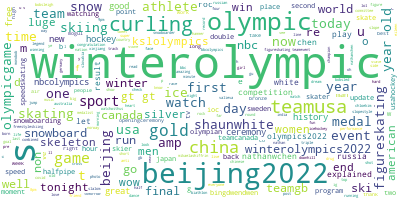

In [9]:
tweets_df = pd.read_csv('data_cleaned.csv', quotechar='"', encoding='utf8')

# get all tweets without duplication
unique_tweets = list(set(list(tweets_df['text'].values)))
unique_tweets = [t for t in unique_tweets if t]

# join the words of the different tweets together into one string
long_string = ' '.join(unique_tweets)
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

## Topic Modelling

### Configuring Stopwords

In [10]:
# get stopwords from nltk library, without outputing the download information to terminal
nltk.download('stopwords', quiet=True)

stop_words = stopwords.words('english')

# add more stopwords
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'winterolympic', 'olympic', 'winterolympics',
                   'olympics', 'beijing','winterparalympic', 'beijing2022', 'winter', 'today', 'like', 
                   'would', 'watch', 'tonight', 'first', 'time', 'go', 'next', 'events', 'let', 
                   'love', 'year', 'watching', 'day', 'run', 'big', 'live', 'know', 'well','going', 'great'
                   , 'get', 'one', 'good', 'th', 'white', 'back','game', 'amp', 'end', 'see', 'watchwithus'
                   , 'much'])

# print(stop_words)
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# get the tweets in a list
data = tweets_df.text.values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)
# print(data_words)

## Get the Mostly Talked Topics

In [11]:
# create a dictionary
id2word = corpora.Dictionary(data_words)

# create a corpus
texts = data_words

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]

# set number of topics
num_topics = 5

# build an LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print keywords in each topic
pprint(lda_model.print_topics())

[(0,
  '0.012*"curling" + 0.010*"gold" + 0.008*"team" + 0.008*"teamusa" + '
  '0.007*"medal" + 0.006*"women" + 0.004*"nbc" + 0.004*"coverage" + '
  '0.004*"snowboard" + 0.004*"sports"'),
 (1,
  '0.012*"team" + 0.011*"curling" + 0.011*"china" + 0.010*"medal" + '
  '0.008*"skating" + 0.008*"gold" + 0.007*"usa" + 0.007*"figure" + 0.007*"men" '
  '+ 0.006*"figureskating"'),
 (2,
  '0.012*"curling" + 0.011*"gold" + 0.008*"women" + 0.007*"opening" + '
  '0.007*"medal" + 0.007*"games" + 0.006*"men" + 0.006*"nathan" + 0.006*"ice" '
  '+ 0.006*"chen"'),
 (3,
  '0.009*"team" + 0.008*"sport" + 0.007*"skiing" + 0.007*"ice" + 0.006*"new" + '
  '0.006*"skating" + 0.006*"speed" + 0.006*"gold" + 0.005*"men" + '
  '0.005*"curling"'),
 (4,
  '0.019*"teamusa" + 0.016*"curling" + 0.015*"gold" + 0.011*"women" + '
  '0.009*"usa" + 0.009*"team" + 0.009*"final" + 0.008*"medal" + 0.008*"figure" '
  '+ 0.007*"skating"')]


### Visualise the topics

In [12]:
doc_lda = lda_model[corpus]

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./'+str(num_topics))

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# uncomment this if you want to save LDAvis_prepared file
# with open(LDAvis_data_filepath, 'wb') as f:
#     pickle.dump(LDAvis_prepared, f)
# f.close()

# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# f.close()

pyLDAvis.save_html(LDAvis_prepared, './saved_topics.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.047901  0.055294       1        1  22.718857
2      0.026364 -0.028466       2        1  21.623867
1      0.006956  0.039429       3        1  19.560705
3     -0.101320  0.006925       4        1  18.360491
0      0.020099 -0.073181       5        1  17.736080, topic_info=          Term         Freq        Total Category  logprob  loglift
112    teamusa  3144.000000  3144.000000  Default  30.0000  30.0000
2        final  1391.000000  1391.000000  Default  29.0000  29.0000
378      sport  1102.000000  1102.000000  Default  28.0000  28.0000
32       medal  2568.000000  2568.000000  Default  27.0000  27.0000
3599   opening  1157.000000  1157.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
573   halfpipe   167.307064   680.737563   Topic5  -5.9996   0.3262
115        usa   233.894281  1898.748980   Topic5  -5.6646  -0.3645
378      sport   180.106159  1102.182490   Topic5  -5.9259  -0.0819
48     skating   174.443912  2271.628572   Topic5  -5.9578  -0.8371
166      games   167.799006  1254.913308   Topic5  -5.9967  -0.2825

[449 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1693      1  0.821417  achievement
1693      2  0.026497  achievement
1693      3  0.132487  achievement
1693      5  0.026497  achievement
228       1  0.147334       action
...     ...       ...          ...
1977      5  0.977612          zhi
815       2  0.787460          zoi
815       3  0.100722          zoi
815       4  0.018313          zoi
815       5  0.091565          zoi

[1065 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 2, 4, 1])

# Hence, from the visualisation above we can conclude, people were mostly talking about these topics for the Winter Olympics:
$ Gold medal $, $curling$, $skating$, $china$, $woman$ and $team USA$

# Task 1: What is the dominant sentiment towards the Winter Olympics?

# Sentiment Analysis

In [13]:
all_pos = 0
all_neg = 0
all_neu = 0
all_compounds = []
dates = np.arange(4, 20)
for date in dates:
    compound = []
    
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    tweets_df_copy = tweets_df.loc[tweets_df['date'].str.contains(cur_date)]
    
    # Removing duplicate tweets
    unique_tweets = list(set(list(tweets_df_copy['text'].values)))
    unique_tweets = [t for t in unique_tweets if t]
    
    analyzer = SentimentIntensityAnalyzer()
    for tweet_text in unique_tweets:
        vs = analyzer.polarity_scores(tweet_text)
        compound_score = vs['compound']
        compound.append(compound_score)
        if compound_score >= 0.05:
            all_pos += 1
        elif compound_score <= -0.05:
            all_neg += 1
        else:
            all_neu += 1
        
    general_compound_score = sum(compound) / len(compound)
    all_compounds.append(general_compound_score)

In [14]:
print(all_compounds)
print(all_pos)
print(all_neg)
print(all_neu)

[0.18926034101673575, 0.16630275534441794, 0.19107737861352792, 0.17718922056384756, 0.18486958923853006, 0.20056868039149517, 0.2531130283441076, 0.17076508549365718, 0.22997968963943427, 0.21609209726443807, 0.21042709760273995, 0.18643103756708412, 0.17659889908256873, 0.20007657885239996, 0.20634046434494197, 0.24031261859582587]
24260
7769
18678


## Visualise the result

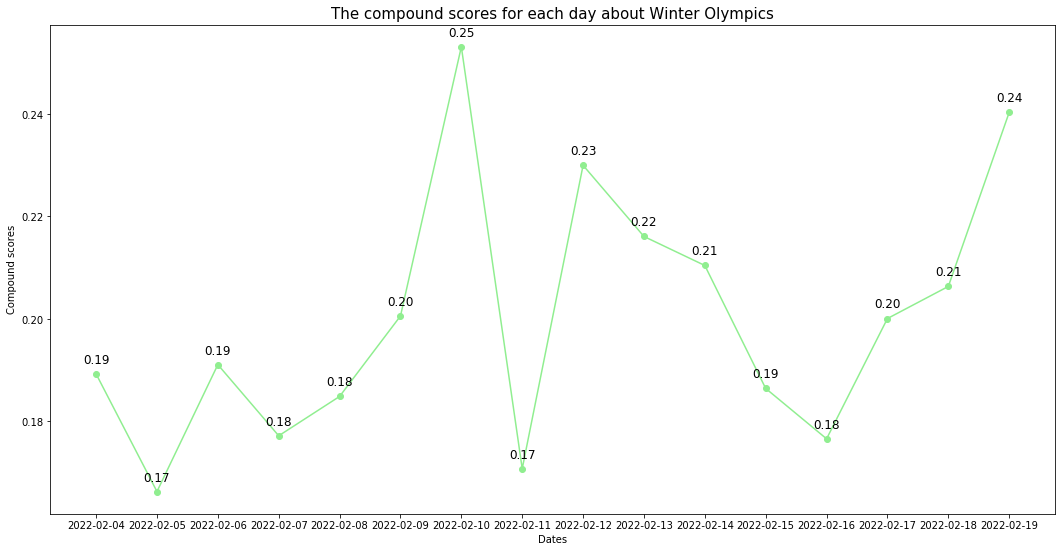

In [15]:
labels = []
for date in dates:
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    labels.append(cur_date)
    
plt.figure(figsize=(18,9))
plt.plot(all_compounds, 'o-', color = 'lightgreen')
plt.xticks(range(len(labels)), labels)
plt.xlabel('Dates')
plt.ylabel('Compound scores')
plt.title("The compound scores for each day about Winter Olympics", fontsize=15)
x = dates
y = np.array(all_compounds)
for _x, _y in zip(x, y):
    plt.text(_x-4, _y+0.0015, '%.2f'%_y, ha='center', va='bottom', size=12, c='black')
plt.show()

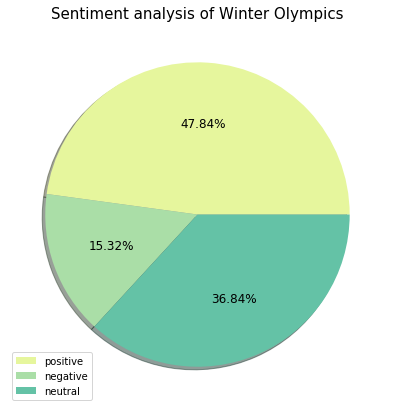

In [16]:
plt.figure(figsize=(7,7))
senti_data = [all_pos, all_neg, all_neu]
labels = ['positive', 'negative', 'neutral']
colours = ['#E6F69D','#AADEA7','#64C2A6']
plt.pie(senti_data,autopct='%1.2f%%',textprops={'fontsize': 12}, colors=colours,shadow=True)
plt.title('Sentiment analysis of Winter Olympics', fontsize=15)
plt.legend(labels)
plt.show()

# Task 3: Which 2 countries have been mostly talked about during Winter Olympics? Which country do people perfer?

# Named Entity Recognition

In [17]:
nlp = spacy.load('en_core_web_trf') # Transformer based pre-trained model 438 MB

In [18]:
countries = {}
stop_words = ['beijing2022', 'beijing']

for tweet_text in unique_tweets:
    doc = nlp(tweet_text)
    for ne in doc.ents:
        if ne.label_ == 'GPE':
            tweet = tweet_text[ne.start_char:ne.end_char]
            if tweet not in stop_words and tweet not in countries.keys():
                countries[tweet] = 1
            elif tweet not in stop_words:
                countries[tweet] += 1

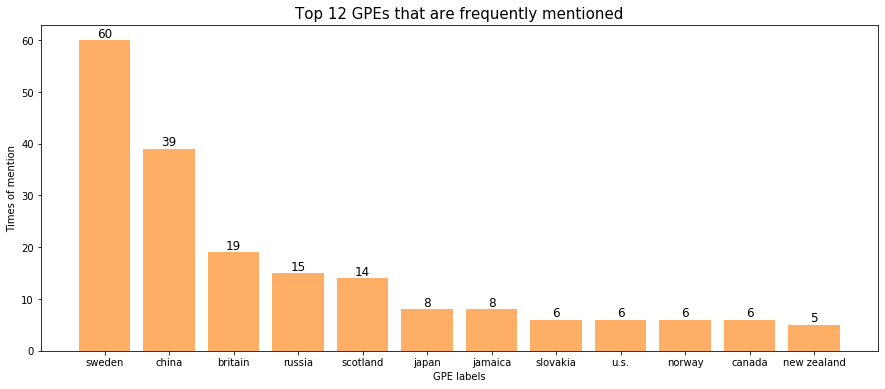

In [19]:
countries = {k: v for k, v in sorted(countries.items(), key=lambda item: item[1], reverse=True)}
names = list(countries.keys())[0:12]
values = list(countries.values())[0:12]
plt.figure(figsize=(15,6))
plt.ylabel('Times of mention')
plt.xlabel('GPE labels')
plt.title('Top 12 GPEs that are frequently mentioned', fontsize=15)

plt.bar(range(12), values, tick_label=names, color = '#FEAE65')
for _x, _y in zip(np.arange(12), values):
    plt.text(_x, _y, _y, ha='center', va='bottom', size=12, c='black')
plt.show()

In [20]:
mostly_talked_country = list(countries.keys())[0]
second_talked_country = list(countries.keys())[1]
print("As the bar chart shows, the 2 mostly talked countries are " + mostly_talked_country + " and " + second_talked_country)

As the bar chart shows, the 2 mostly talked countries are sweden and china


In [21]:
all_pos_m = 0
all_neg_m = 0
all_neu_m = 0
all_compounds_m = []
dates = np.arange(4, 20)
for date in dates:
    compound = []
    
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    tweets_df_copy = tweets_df.loc[tweets_df['date'].str.contains(cur_date)]
    tweets_df_copy = tweets_df_copy.loc[tweets_df_copy['text'].str.contains(mostly_talked_country)]
    # Removing duplicate tweets
    unique_tweets = list(set(list(tweets_df_copy['text'].values)))
    unique_tweets = [t for t in unique_tweets if t]
    
    analyzer = SentimentIntensityAnalyzer()
    for tweet_text in unique_tweets:
        vs = analyzer.polarity_scores(tweet_text)
        compound_score = vs['compound']
        compound.append(compound_score)
        if compound_score >= 0.05:
            all_pos_m += 1
        elif compound_score <= -0.05:
            all_neg_m += 1
        else:
            all_neu_m += 1
        
    general_compound_score = sum(compound) / len(compound)
    all_compounds_m.append(general_compound_score)

In [22]:
all_pos_s = 0
all_neg_s = 0
all_neu_s = 0
all_compounds_s = []
dates = np.arange(4, 20)
for date in dates:
    compound = []
    
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    tweets_df_copy = tweets_df.loc[tweets_df['date'].str.contains(cur_date)]
    tweets_df_copy = tweets_df_copy.loc[tweets_df_copy['text'].str.contains(second_talked_country)]
    # Removing duplicate tweets
    unique_tweets = list(set(list(tweets_df_copy['text'].values)))
    unique_tweets = [t for t in unique_tweets if t]
    
    analyzer = SentimentIntensityAnalyzer()
    for tweet_text in unique_tweets:
        vs = analyzer.polarity_scores(tweet_text)
        compound_score = vs['compound']
        compound.append(compound_score)
        if compound_score >= 0.05:
            all_pos_s += 1
        elif compound_score <= -0.05:
            all_neg_s += 1
        else:
            all_neu_s += 1
        
    general_compound_score = sum(compound) / len(compound)
    all_compounds_s.append(general_compound_score)

## Visualise the result

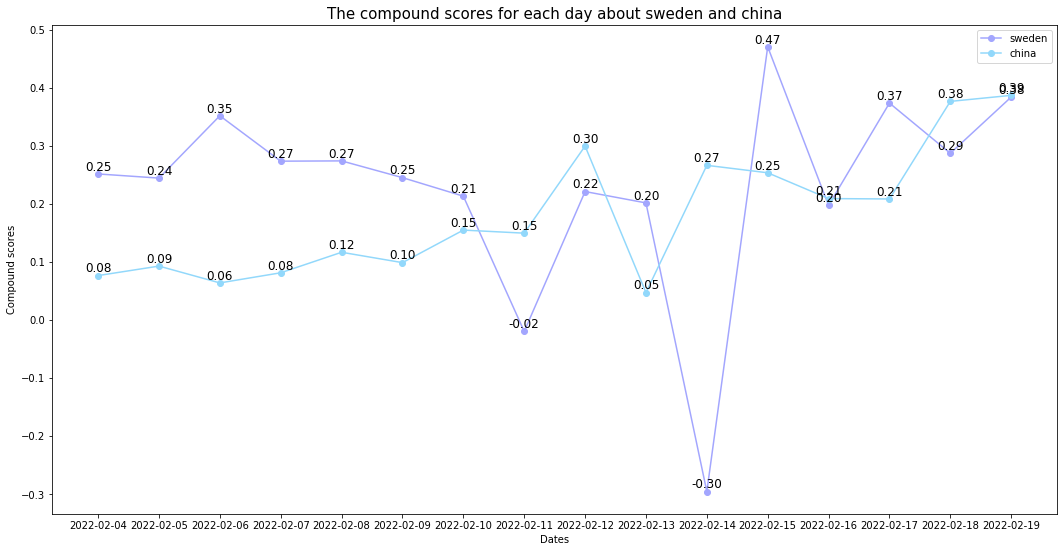

/Users/cyc/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/cyc/anaconda3/lib/python3.7/site-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/Users/cyc/anaconda3/lib/python3.7/site-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/Users/cyc/anaconda3/lib/python3.7/site-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/Users/cyc/anaconda3/lib/python3.7/site-packages/scipy/sparse/sputils.py:17: DeprecationWarning:

/Users/cyc/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/cyc/anaconda3/lib/python3.7/site-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/Users/cyc/anaconda3/lib/python3.7/site-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/Users/cyc/anaconda3/lib/python3.7/site-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/Users/cyc/anaconda3/lib/python3.7/site-packages/scipy/sparse/sputils.py:17: DeprecationWarning:

/Users/cyc/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/cyc/anaconda3/lib/python3.7/site-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/Users/cyc/anaconda3/lib/python3.7/site-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/Users/cyc/anaconda3/lib/python3.7/site-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/Users/cyc/anaconda3/lib/python3.7/site-packages/scipy/sparse/sputils.py:17: DeprecationWarning:

/Users/cyc/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/cyc/anaconda3/lib/python3.7/site-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/Users/cyc/anaconda3/lib/python3.7/site-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/Users/cyc/anaconda3/lib/python3.7/site-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/Users/cyc/anaconda3/lib/python3.7/site-packages/scipy/sparse/sputils.py:17: DeprecationWarning:

In [23]:
labels = []
for date in dates:
    if date >= 10:
        cur_date = '2022-02-%s'
    else:
        cur_date = '2022-02-0%s'
    cur_date = cur_date%date
    labels.append(cur_date)
    
plt.figure(figsize=(18,9))
plt.plot(all_compounds_m, 'o-', color = '#A3A6FE', label = mostly_talked_country)
plt.plot(all_compounds_s, 'o-', color = '#92D8FB', label = second_talked_country)
plt.xticks(range(len(labels)), labels)
plt.xlabel('Dates')
plt.ylabel('Compound scores')
title_plt = "The compound scores for each day about " + mostly_talked_country + " and " + second_talked_country
plt.legend()
plt.title(title_plt, fontsize=15)
x = dates
y1 = np.array(all_compounds_m)
y2 = np.array(all_compounds_s)
for _x, _y1, _y2 in zip(x, y1, y2):
    plt.text(_x-4, _y1+0.0015, '%.2f'%_y1, ha='center', va='bottom', size=12, c='black')
    plt.text(_x-4, _y2+0.0015, '%.2f'%_y2, ha='center', va='bottom', size=12, c='black')
plt.show()

In [ ]:
plt.figure(figsize=(7,7))
senti_data = [all_pos_m, all_neg_m, all_neu_m]
labels = ['positive', 'negative', 'neutral']
colours = ['#E6F69D','#AADEA7','#64C2A6']
plt.pie(senti_data,autopct='%1.2f%%',textprops={'fontsize': 12}, colors=colours,shadow=True)
title_plt = "Sentiment analysis of " + mostly_talked_country
plt.title(title_plt, fontsize=15)
plt.legend(labels)
plt.show()

In [ ]:
plt.figure(figsize=(7,7))
senti_data = [all_pos_s, all_neg_s, all_neu_s]
labels = ['positive', 'negative', 'neutral']
colours = ['#E6F69D','#AADEA7','#64C2A6']
plt.pie(senti_data,autopct='%1.2f%%',textprops={'fontsize': 12}, colors=colours,shadow=True)
title_plt = "Sentiment analysis of " + second_talked_country
plt.title(title_plt, fontsize=15)
plt.legend(labels)
plt.show()

# Named Entity Linking

In [ ]:
# nlp = spacy.load("en_core_web_md")

# #add to pipeline
# nlp.add_pipe('entityLinker', last=True)

In [ ]:
# for tweet_text in unique_tweets:
#     try:
#         doc = nlp(tweet_text)
#         print(tweet_text)
#         all_linked_entities = doc._.linkedEntities
#         for linked_entity in all_linked_entities:
#             print(linked_entity.get_url() + ' ' + linked_entity.pretty_string(True))
#         print()
#     except:
#         pass